<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/02_CNN_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks

This tutorial addresses the basic concepts regarding Convolutional Neural Networks and their implementation using the Keras framework.
Convolutional Neural Networks (CNNs) are a class of feed-forward artificial neural architecture. They are applied to analyse visual 2D imagery, meaning that we can feed images directly into a CNN without the need to flatten them into a 1D vector as done in the previous tutorial.
CNNs have revolutionised the field of computer vision in the last decade. In 2012 Alex Krizhevsky introduced the AlexNet architecture to win the ImageNet Challenge (one of the most important competitions on image classification within the Computer Vision community), by reducing the top-5 error more than 10 percentage points, which was an incredible improvement at that time. As of now, CNNs are used not only on image classification but in many other computer vision tasks.

![](https://cdn-5f733ed3c1ac190fbc56ef88.closte.com/wp-content/uploads/2017/03/alexnet_small-1.png)

The image above is from [cv-tricks' blog](https://cv-tricks.com/cnn/understand-resnet-alexnet-vgg-inception/) and shows the proposed AlexNet architecture. It is composed of 5 convolutional layers followed by 3 fully connected layers. Nowadays, we can find much deeper and more complex architectures, which outperform AlexNet on the ImageNet Challenge. 







## CNN Structure

The basic pipeline of common CNNs consists of an image as input and a stack of convolutional layers that extract a feature representation from the input image. The final shape of the image representation is conditioned on the type of problem/task that the architecture is facing. For instance, the output of the last layer in a classification problem is a probability vector. Each dimension of the probability vector represents how likely is that the input image belongs to a specific class. However, the architecture design is up to us, and therefore, we could code a network that outputs a single value for regression problems, or that generates a new image map for semantic segmentation. Now, let's dig in a bit into CNN and introduce some layers that are widely used. 

### 2D Convolutional Layer

The most common layer in any CNN architecture is the 2D convolutional layer. Convolutional layers are specifically designed to extract features from images or even extract features from previously extracted features. As shown in the following illustration, 2D convolutions apply the same filter to the full image. And therefore, due to its nature, 2D convolutional filters exploit the local information presented in images, making them a powerful tool for image analysis. 

![](https://cdn-images-1.medium.com/max/800/1*Fw-ehcNBR9byHtho-Rxbtw.gif)

Image [source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1).

The latest deep learning frameworks have made possible the integration of convolutional layers easily on our architectures with only a single line of code. We will address here how 2D convolutions work since full understanding is needed to comprehend how any CNN operates. The following images and some explanations can be further explored on the original [Irhum Shafkat's blog](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) or in the [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/) book. Both are strongly recommended.

To understand 2D convolutions, we need to define first what a kernel is. Kernels are simply matrices of numbers. The numbers on the kernels are the so-called weights, and the weights on the kernels change as we train the network. Hence, network training aims to optimise the network's parameters (update the kernel weights) such that the cost function is minimised. 

The 2D convolution operation takes the network's kernels and "slides" them over the input image (alike to a sliding window) as in the following image from [PyImageSearch](https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/) blog:

![](https://pyimagesearch.com/wp-content/uploads/2014/10/sliding_window_example.gif)

In each step, the network performs an element-wise multiplication with the elements that are currently on. The results of this elementwise multiplication are added to obtain the output value of the operation. CNNs repeat previous step for all the positions of the sliding window, composing at the end the feature map. This generated feature map can go through another 2D convolutional layer and create more powerful features. 

> 

![](https://cdn-images-1.medium.com/max/800/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

> 
The previous image shows the 2D convolution operation. Thus, the new feature values are the weighted sum of all the elements in the sliding window after the elementwise multiplication between input and kernel.  The bigger the size of the kernel is, the more feature elements contribute to the final output value. In contrast to fully connected layers, where a new feature value is a weighted sum over **all** input values, as mentioned, 2D convolutions compute features based on local areas. In other words, instead of looking at every input component, they consider only features coming from close locations. 

In the above example, the input image on the left has a size of 5x5 and the dimension of the resulting feature map is 3x3, showing that the size of the output maps is not always equal to the input. Hence, the output size can be computed by doing:

$O = W - K + 1$,

where $O$ is the output height/length, $W$ is the input height/length and $K$ is the kernel size. The output size is not only conditioned on the input size but also on the kernel size. Check in the following code cell how the output feature map shape changes as you increase the kernel size. In Keras, we define the layer by using `Conv2D` from `keras.layers` (documentation [here](https://keras.io/layers/convolutional/#conv2d)).









In [ ]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D

# Generate dummy data
input_feature = np.random.random((1, 100, 100, 1))

# input: 100x100 image with 1 channels -> (100, 100, 1) tensor.
# this applies 1 convolution filter of size 3x3 each.
model = Sequential()
model.add(Conv2D(1, (3, 3), input_shape=(100, 100, 1)))

output_feature = model.predict(input_feature)

print('Input size: ({:}, {:})'.format(input_feature.shape[1], input_feature.shape[2]))
print('Output size: ({:}, {:})'.format(output_feature.shape[1], output_feature.shape[2]))

Input size: (100, 100)
Output size: (98, 98)


Moreover, the kernel size and the input size are not the only parameters affecting the output size. We are going to introduce two extra elements that change the size of the output map: the padding and the stride.

### Adding Padding to Input Features

In some tasks, such as [image translation](https://arxiv.org/pdf/1611.07004.pdf), we need the output size to be equal to the input size. The solution to that is using padding, where extra edges are added to the input features so that the dimension is not reduced after the convolutional layer. Normally those pixels have $0$ value (termed zero-padding), but depending on the application other methods could be used, e.g., reflection or symmetric padding.

![](https://cdn-images-1.medium.com/max/800/1*1okwhewf5KCtIPaFib4XaA.gif)

If padding is used, the new output size can be computed by doing:

$O = W - K + 2P+ 1$, 

where $P$ is the padding value. $P$ must be set in concordance with the kernel size if dimensionality wants to be preserved. Padding can be added to the `Conv2d` layer in Keras by using the padding argument and selecting one of the two settings: `valid`, which is the default value and means no padding; and `same`, which adapts the padding value to have the same output size as input size.

In [ ]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D

# Generate dummy data
input_feature = np.random.random((1, 100, 100, 1))

# input: 100x100 image with 1 channels -> (100, 100, 1) tensor.
# this applies 1 convolution filter of size 3x3 each.
# attribute padding='same' applies zero-padding to the input feature map
model = Sequential()
model.add(Conv2D(1, (3, 3), input_shape=(100, 100, 1), padding='same'))

output_feature = model.predict(input_feature)

print('Input size: ({:}, {:})'.format(input_feature.shape[1], input_feature.shape[2]))
print('Output size: ({:}, {:})'.format(output_feature.shape[1], output_feature.shape[2]))

Input size: (100, 100)
Output size: (100, 100)


### Using Stride in Convolutional Layers

The stride operation allows the convolutional layers to skip some of the sliding windows explained above. Hence, instead of jumping one pixel apart, we can define the number of skipped elements before computing the weighting sum between the kernel's weights and input features. A stride of 1 means that features will be extracted from all windows a pixel apart, so basically, every single window is computed. A stride of 2 means that we are selecting windows 2 pixels apart, skipping every other window in the process. Strides reduce the number of computations and consequently the size of the output map. In practice, as we go deeper into the CNN, the spatial size of the feature map gets smaller while the number of channels increases. Moreover, we can further reduce the size of the feature map using pooling operations, which we introduce later in this tutorial.

![](https://cdn-images-1.medium.com/max/800/1*BMngs93_rm2_BpJFH2mS0Q.gif)

If strides are used, the new output size can be computed as:

$O = \dfrac{W - K + 2P}{S}+ 1$, 

where $S$ is the stride value. The stride is set in the layer by using the `strides` argument.

In [ ]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D

# Generate dummy data
input_feature = np.random.random((1, 100, 100, 1))

# input: 100x100 image with 1 channels -> (100, 100, 1) tensor.
# this applies 1 convolution filter of size 3x3 each.
# attribute padding='same' applies zero-padding to the input feature map
# attribute strides=2 applies applies stride of 2
model = Sequential()
model.add(Conv2D(1, (3, 3), input_shape=(100, 100, 1), padding='same', strides=2))

output_feature = model.predict(input_feature)

print('Input size: ({:}, {:})'.format(input_feature.shape[1], input_feature.shape[2]))
print('Output size: ({:}, {:})'.format(output_feature.shape[1], output_feature.shape[2]))

Input size: (100, 100)
Output size: (50, 50)


## Differences Between Kernel and Filters

The examples above take as input a single-channel image and compute a feature map with also one channel. However, when dealing with RGB images or feature maps, the input is no longer a single-channel map but, instead, they can have multiple channels. In the case of an RGB image, for each 2D convolution, we will need to define 3 kernels to interact with each of the image's channel colours. This group of kernels is called a filter. Thus, a filter is a collection of kernels that produces a single output.

As a regular practice when defining Deep Learning models, we increase the number of filters in each convolutional layer as we go deeper into the model. Due to the element-wise multiplication, the number of kernels on each filter must be the same that the number of channels in the input feature map. Keras already deals with the number of kernels inside each filter. Keras keeps track of the input size in each convolutional layer unlike other frameworks (Pytorch or TensorFlow). Hence, in Keras, we must only decide the number of filters (output channels) in each layer.

The next figure shows how the convolution is performed when having three input channels. First, one filter uses its three independent kernels to convolve with the RGB channels of the input image:

![](https://cdn-images-1.medium.com/max/1000/1*8dx6nxpUh2JqvYWPadTwMQ.gif)

Next, each of the processed feature maps is added together to obtain a single channel:

![](https://cdn-images-1.medium.com/max/1000/1*CYB2dyR3EhFs1xNLK8ewiA.gif)

Finally, we add the bias term to obtain the feature map. There is a single bias for the full output channel map. This operation is repeated for all the filters inside the convolutional layer.

Now, we show how to use a `Conv2D` layer that takes an input image with 3 channels and generates an output map with 32 channels.


In [ ]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D

# Generate dummy data
input_feature = np.random.random((1, 100, 100, 3))

# input: 100x100 image with 3 channels -> (100, 100, 3) tensor.
# this applies 32 convolution filters of size 3x3 each.
# attribute padding='same' applies zero-padding to the input feature map
# attribute strides=2 applies applies stride of 2
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3), padding='same', strides=2))

output_feature = model.predict(input_feature)

print('Input size: ({:}, {:}, {:})'.format(input_feature.shape[1], input_feature.shape[2], input_feature.shape[3]))
print('Output size: ({:}, {:}, {:})'.format(output_feature.shape[1], output_feature.shape[2], output_feature.shape[3]))

Input size: (100, 100, 3)
Output size: (50, 50, 32)


## Activation Functions

As seen in previous tutorials, after a `Dense` layer we usually can find an activation function. We introduce here how to use them after `Conv2D` layers. Those activation functions are a set of operators that maps the feature values to a new set of values, the mapping depends on the function at hand. The main reason for using activation functions is that they add non-linearities to the network, giving more expressive power to the network, which will be able to reproduce more complex functions. 


The complete list of activation functions that Keras offers can be found [here](https://keras.io/activations/). We introduce here some of them:

*  **Sigmoid Function** sets the output in the range (0, 1). The sigmoid function is widely used in binary classification problems since its output can be taken as a probability value. `keras.activations.sigmoid(x)`:

>![](https://i.ibb.co/Ph8dsTv/sigmoid.png)

*  **Tanh Function** is a logistic function as sigmoid, but the range of the tanh function is (-1, 1). Contrary to sigmoid function, where the values close to 0 are set around 0.5, in the tanh function they will be still mapped around the 0 value. `keras.activations.tanh(x)`:

>![](https://i.ibb.co/68g7LpL/tanh.png)

*  **ReLU Function** is the most common activation function you can find in any current CNN as in general works better than the rest. The range of this function is in \[0, inf). It sets all negative values to 0 and hence is computationally easy to implement. As a drawback, during training some neurons *die*, meaning that the output is 0 for all available data points and no gradient is propagated there. `keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)`:

>![](https://i.ibb.co/Zd9H8Z4/relu.png)

*  **LeakyReLU Function** is a modified version of the ReLU activation above, which attempts to solve the problem of dying neurons that ReLU has. While ReLU does not backpropagate negative values, Leaky ReLU smooths those values without setting them to 0. That allows the gradients to backpropagate through the network even for negative values. `keras.layers.LeakyReLU(alpha=0.3)`:

>![](https://i.ibb.co/dmnJ6h1/leakyrelu.png)

*  **Softmax Function** is another widely activation function for multi-class classification problems and usually is employed as the last activation function in the classification model. This function sets all of the output elements to the range (0, 1). However, the softmax function does not take independently the input values to map it into its probability value. Softmax Function takes an un-normalized vector, $s$, and normalizes it into a probability distribution, $p$, following the softmax expression. As the output is a probability, the output elements add up to 1. `keras.activations.softmax(x, axis=-1)`. Thus, the output value $p_i$ is computed as:

> $p_{i} = \dfrac{e^{s_i}}{\sum_{\substack{j}}^{N} e^{s_j}}$

The following example shows the feature maps before and after of the ReLU activation function. All values that are negative are set to 0 after the activation function.




In [ ]:
import numpy as np
import keras
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation

# Generate dummy data
input_feature = np.random.random((1, 3, 3, 1)) - 0.5

# input: 3x3 image with 1 channel -> (3, 3, 1) tensor.
# This applies a 1 convolution filter of size 3x3 each.
# This applies a ReLU activation function
model = Sequential()
model.add(Conv2D(1, (3, 3), input_shape=(3, 3, 1), padding='same', strides=1, name='conv'))
model.add(Activation('relu'))

model_before_ReLU = Model(inputs=model.input, outputs=model.get_layer('conv').output)

output_feature = model_before_ReLU.predict(input_feature)
output_ReLu_feature = model.predict(input_feature)

print('Output Network without activation function')
print(output_feature)

print('')
print('Output Network after ReLU activation function')
print(output_ReLu_feature)


Output Network without activation function
[[[[ 0.23390736]
   [ 0.2609628 ]
   [-0.10049579]]

  [[ 0.47150436]
   [ 0.01826818]
   [-0.0576808 ]]

  [[ 0.08542764]
   [ 0.02355585]
   [ 0.09083541]]]]

Output Network after ReLU activation function
[[[[0.23390736]
   [0.2609628 ]
   [0.        ]]

  [[0.47150436]
   [0.01826818]
   [0.        ]]

  [[0.08542764]
   [0.02355585]
   [0.09083541]]]]


## Pooling Layer

It is a common practice to insert a pooling layer between convolutional layers in CNNs. In a standard CNN architecture, we set the feature sizes to become smaller progressively to reduce the computation in the networks, and to merge the information from different spatial locations. To reduce the feature map sizes, we can either use bigger stride size in the convolutional layers or we can use pooling layers. Pooling layers perform a spatial sliding window and apply an operation to reduce the spatial size. Those operations vary depending on the architecture, being the max, mean and min pooling the most typical ones. Here, we will explain the max pooling, although all the others work similarly. Max pooling keeps only the max value in a neighbourhood, where the neighbourhood is defined by the size of the kernel. Let's visualise it, the next example shows the result of a Max Pooling layer with a 2x2 kernel and a stride of 2.

![](https://i.ibb.co/Xp454S4/MaxPool.png)

As in convolutional layers, the final size is conditioned to the stride size of the pooling layer. However, contrary to convolutional layers, pooling layers operate independently on each of the input channels, without modifying the depth of the feature maps. To add max pooling to our model we need to import `MaxPooling2d` from `keras.layers` and define the stride and pooling size.

In [ ]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D

# Generate dummy data
input_feature = np.random.random((1, 100, 100, 3))

# input: 100x100 image with 3 channels -> (100, 100, 3) tensor.
# this applies 32 convolution filters of size 3x3 each.
# attribute padding='same' applies zero-padding to the input feature map
# attribute strides=1 applies applies stride of 1
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3), padding='same', strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

output_feature = model.predict(input_feature)

print('Input size: ({:}, {:}, {:})'.format(input_feature.shape[1], input_feature.shape[2], input_feature.shape[3]))
print('Output size: ({:}, {:}, {:})'.format(output_feature.shape[1], output_feature.shape[2], output_feature.shape[3]))

Input size: (100, 100, 3)
Output size: (50, 50, 32)


# Example: Classification on MNIST

As opposed to the *Introduction to Keras* tutorial, in this section, we show how to perform image classification when the input data is a 2D image instead of a flat 1D vector. 

As discussed above, Convolutional Neural Networks aim to extract and exploit the local relationships on 2D maps, hence, CNNs are much more convenient for images than Multi-layer Perceptron models. 

First of all, we load the MNIST dataset from Keras' framework. The definition of the data is almost identical than in the Keras tutorial, although this time we are not reshaping the input images into a 1D vector.

In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.utils import np_utils
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Flatten
import numpy as np

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

shape = x_train.shape

# Normalize and reshape the input images
x_train = np.expand_dims(x_train.astype('float32'), -1)
x_test = np.expand_dims(x_test.astype('float32'), -1)

x_train /= 255
x_test /= 255

y_train_class = np_utils.to_categorical(y_train, 10)
y_test_class = np_utils.to_categorical(y_test, 10)

print('Image shape: {0}'.format(x_train.shape[1:]))
print('Total number of training samples: {0}'.format(x_train.shape[0]))
print('Total number of test samples: {0}'.format(x_test.shape[0]))

11493376/11490434 [==============================] - 0s 0us/step
Image shape: (28, 28, 1)
Total number of training samples: 60000
Total number of test samples: 10000


As illustrated in the cell, this time the input image before the model is 28x28x1. 

Now we can define a model composed of convolutional layers, activation functions, and maxpool operators:

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

As explained in the previous tutorial, in a classification problem, the output of the model is a probability vector. Each dimension of the vector indicates how likely is that the input image belongs to a specific class. 

Up to now, the resulting feature map of the model is a map with the shape *Batch x Weight' x Height' x Channel*, and it needs to be mapped into a vector with shape *Batch x Num Classes*. A common technique to process this mapping is to add a Flatten layer that will reshape the feature map to *Batch x (Weight' * Height' * Channel)*. Following the Flatten layer, we add a dense layer which maps this new feature map to the desired output size. 

In [ ]:
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))

Let's visualize the output shape in each layer.

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)              

Finally, we can train our CNN and check its performance on MNIST. 

In [ ]:
# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(x_train, y_train_class, batch_size=32, epochs=10,  verbose=0)

score = model.evaluate(x_test, y_test_class, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0758802592754364
Test accuracy: 0.9757000207901001


# Coursework


## Task 1: Classification

At this point, we know what is a CNN, how they work, and the components needed to design them. In this first task, we want you to create a CNN that is able to outperform the Multi-layer Perceptron model from Tutorial 1. For the first part of the coursework, we train on CIFAR10, a  classical dataset for image classification. Let's first load the dataset and visualise some examples:

170500096/170498071 [==============================] - 3s 0us/step
Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of test samples: 10000


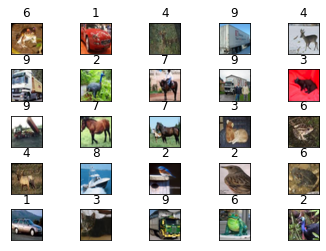

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.optimizers import RMSprop

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of test samples: {0}'.format(X_test.shape[0]))

# Let's visualize some examples
N=5
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
items = list(range(0, 10))
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    axes[row,col].imshow(X_train[idx], cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    y_target = int(y_train[idx])
    target = str(items[y_target])
    axes[row,col].set_title(target)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

CIFAR10 contains 50,000 32x32 color training images, labeled over 10 categories and 10,000 test images. We need to preprocess the images for the 1D neural network defined in the previous tutorial:

In [2]:
# Preprocess dataset for a 1D neural network
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the image
X_train /= 255
X_test /= 255

X_train_flatten = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]*3)
X_test_flatten = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]*3)

print('New X_train shape: {0}'.format(X_train_flatten.shape))

Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)

print('New Y_train shape: {0}'.format(Y_train_class.shape))


New X_train shape: (50000, 3072)
New Y_train shape: (50000, 10)


Now, we are ready to define the Multi-layer Perceptron model and train it.

In [3]:
model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(X_train_flatten.shape[1:])))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train_flatten, Y_train_class, batch_size=32, epochs=20)

score = model.evaluate(X_test_flatten, Y_test_class, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
1563/1563 [==============================] - 8s 3ms/step - loss: 2.0444 - accuracy: 0.2509
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.7797 - accuracy: 0.3571
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6904 - accuracy: 0.3926
Epoch 4/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6327 - accuracy: 0.4170
Epoch 5/20
1563/1563 [==============================] - 5s 4ms/step - loss: 1.5882 - accuracy: 0.4304
Epoch 6/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5513 - accuracy: 0.4469
Epoch 7/20
1563/1563 [==============================] - 5s 4ms/step - loss: 1.5138 - accuracy: 0.4611
Epoch 8/20
1563/1563 [==============================] - 5s 4ms/step - loss: 1.4984 - accuracy: 0.4639
Epoch 9/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4730 - accuracy: 0.4700
Epoch 10/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.448

### Problem Definition

In this exercise, you are asked to test several CNN architectures in the code provided below. Do not modify the optimizer, loss used or parameters related to the training such as the learning rate, they will be investigated in future tutorials. You must focus on the architecture itself: number of convolutional layers, number of filters in every layer, activation functions, pooling operators, among others. Batch Normalization and Dropout layers, which are quite used in CNN architectures, will be also investigated in a future tutorial so you do not have to discuss them.


**Report**:
*   Present a bar figure with the test and training accuracies for different design choices. Discuss only the parameters that have a significant influence on the network's performance. Explain any discrepancy between training and test accuracies.
*   Present a sketch that introduces your best architecture. See some examples on how to display networks in [cv-tricks' blog](https://cv-tricks.com/cnn/understand-resnet-alexnet-vgg-inception/).


In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Flatten

# the data, shuffled and split between train and val sets
# Here we are using the official test set as our validation set, in further
# tutorials, test and validation splits will be explained properly.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(x_train.shape[1:]))
print('Total number of training samples: {0}'.format(x_train.shape[0]))
print('Total number of test samples: {0}'.format(x_test.shape[0]))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the image
x_train /= 255
x_test /= 255

y_train_class = np_utils.to_categorical(y_train, 10)
y_test_class = np_utils.to_categorical(y_test, 10)


# . . . 


# Define here your architecture


# . . . 


# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(x_train, y_train_class, batch_size=32, epochs=20)

score = model.evaluate(x_test, y_test_class, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


---
---

## Task 2: Regression

Now we face a regression task instead of a classification problem. Loss function, activations, and dataset will change in the following task. Thus, instead of having one vector with the probabilities of each class, in this regression problem, the output is a single scalar. 

For this second task, we chose the task of estimating house prices based on input images. To get the data run the following script, which clones Ahmed and Moustafa’s [repository](https://github.com/emanhamed/Houses-dataset) into colmap.

In [ ]:
!git clone https://github.com/emanhamed/Houses-dataset
%cd /content/Houses-dataset/Houses\ Dataset

This dataset contains four images of the house (kitchen, frontal, bedroom and bathroom), and attributes (number of bedrooms, number of bathrooms, zip code...). For our exercise, we only use the images of the house. We start with front door images. 

We have selected frontal images. You can switch to the kitchen, frontal, bedroom or bathroom images by changing house_section variable.


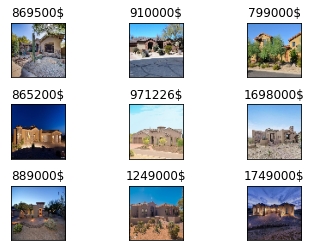

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed

house_section = 'frontal' # select between: kitchen, frontal, bedroom or bathroom
print('We have selected {} images. You can switch to the kitchen, frontal, bedroom or bathroom images by changing house_section variable.'.format(house_section))
images = []
for i_im in range(1, 536):
  image = cv2.imread(str(i_im)+'_'+house_section+'.jpg')
  image = cv2.resize(image, (64, 64))
  images.append(image)

labels = []
f = open('HousesInfo.txt', "r")
for x in f:
  label = (x).split(' ')[-1].split('\n')[0]
  labels.append(label)

# Let's visualize some examples
N=3
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col    
    tmp = cv2.cvtColor(images[idx],cv2.COLOR_BGR2RGB)
    axes[row,col].imshow(tmp, cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    target = int(labels[idx])
    axes[row,col].set_title(str(target) + '$')
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Prepare the dataset for training the model:

In [ ]:
seed(1234)
images = np.asarray(images).astype('float32')
labels = np.asarray(labels).astype('float32')

# Normalize the image
max_price = labels.max()
images /= 255.
labels /= max_price

random_idx = np.random.permutation(len(images))
images = images[random_idx]
labels = labels[random_idx]

split_size_val = int(0.8*len(images))
X_train, X_val = images[:split_size_val], images[split_size_val+1:]
Y_train, Y_val = labels[:split_size_val], labels[split_size_val+1:]

# Print shape of training and test images 
print('X_train image shape: {0}'.format(X_train.shape))
print('X_val image shape: {0}'.format(X_val.shape))

# Print shape of training and test labels 
print('Y_train labels shape: {0}'.format(Y_train.shape))
print('Y_val labels shape: {0}'.format(Y_val.shape))

X_train image shape: (428, 64, 64, 3)
X_val image shape: (106, 64, 64, 3)
Y_train labels shape: (428,)
Y_val labels shape: (106,)


### Problem Definition

Similar to the previous task, you are asked to design a CNN architecture able to perform the estimation of house prices based on the `frontal` house image. Design a new model by changing parameters such as the number of convolutional layers, activation functions, strides, or pooling operators, among others.

In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten
tf.random.set_seed(1234)

chanDim = -1
model = Sequential()

# . . . 


# Define here your architecture


# . . . 

model.summary()
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt, metrics=['mean_absolute_percentage_error'])

# train the model
print("[INFO] training model...")
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=32)

The metric used in this problem to evaluate the performance is the same we used for training the model, the mean absolute percentage error. Mean absolute percentage error is defined as $\frac{100}{n} \sum_n \frac{|\hat{y} - y|}{|y|}$ where $y$ is the ground-truth, $\hat{y}$ is the estimation of the model and `n` the number of elements in the set we are evaluating.

In [ ]:
prices_predicted = model.predict(X_val).flatten()
diff = ((prices_predicted - Y_val) / Y_val) * 100
error_mean = np.mean(np.abs(diff))

print("Predicting house prices - Estimation Error: {:.2f}%".format(error_mean))

**Report**:


*   Propose a CNN architecture that has an estimation error in the validation set below 75%. 
*   Present a figure showing the training and validation loss vs the number of training iterations for different architectural design choices. Discuss the gap between the training and validation loss depending on the proposed architecture.
*   Report a table with results when using any of the other images from the house (kitchen, bedroom, and bathroom).